# Modeling

## Importing modules and data

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

train = pd.read_csv('../data/train_model_ready.csv')
test = pd.read_csv('../data/test_model_ready.csv')

### Setting up Pipeline and gridsearch

In [2]:
pipe_ridge = Pipeline([('ss', StandardScaler()),
                       ('fsel_var', VarianceThreshold()),
                       ('ridge', Ridge())])

pipe_lasso = Pipeline([('ss', StandardScaler()),
                       ('fsel_var', VarianceThreshold()),
                       ('lasso', Lasso())])

pipe_elastic = Pipeline([('ss', StandardScaler()), 
                    ('fsel_var', VarianceThreshold()),
                    ('elastic', ElasticNet())])

pipe_linear = Pipeline([('ss', StandardScaler()), 
                        ('fsel_var', VarianceThreshold()),
                        ('linreg', LinearRegression())])

## OLS regression - pre-scaling





In [73]:
features = [x for x in train.columns if x not in ['saleprice', 'id', 'pid']]

X = train[features]
y = train.saleprice

lr = LinearRegression()

lr.fit(X, y)

lr.predict(X)
lr.score(X, y)

0.9432640203261465

In [74]:
test_features_list = [x for x in test.columns if x not in ['id', 'pid']]

test_features = test[test_features_list]

## Creating train/test splits

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Linear model

In [76]:
linear_params = {}
gs_linear = GridSearchCV(pipe_linear, linear_params)
gs_linear.fit(X_train, y_train)
gs_linear.score(X_train, y_train)

0.863702398699875

In [77]:
gs_linear.score(X_test, y_test)

0.8554104461180603

In [78]:
np.sqrt(mean_squared_error(y_test, gs_linear.predict(X_test)))

0.15543820344886247

In [79]:
gs_linear.best_score_

0.8565681941908005

Our linear model after feature selection seems to be doing well. 85.5% of the variation in the data is being explained by the model.

In [80]:
def plot_coef(model, top_n = 10):
    '''
    Plots the magnitude of top and bottom n coefficients
    '''
    cols = X_train.columns
    coef = model.coef_
    zipped = list(zip(cols, coef))
    zipped.sort(key=lambda x: x[1], reverse = True)
    top_10 = pd.DataFrame(zipped).head(top_n)
    bottom_10 = pd.DataFrame(zipped).tail(top_n)
    return pd.concat([top_10], axis=0).plot.barh(x = 0, y = 1)

In [81]:
list(zip(X_train.columns, gs_linear.best_estimator_.named_steps.linreg.coef_))

[('lot_area', 0.128289793835526),
 ('overall_qual', 0.06204147731118621),
 ('overall_cond', 0.05096834112808959),
 ('year_built', 0.0617670088009992),
 ('year_remod/add', 0.0326075564993411),
 ('total_bsmt_sf', 0.11928938640052478),
 ('1st_flr_sf', 0.008925285711955928),
 ('gr_liv_area', 0.00034180137925961333),
 ('totrms_abvgrd', -0.014271068512430722),
 ('has_masonry', -0.038699139553091975)]

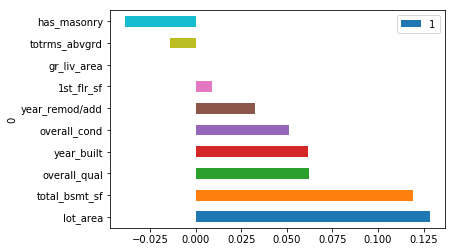

In [82]:
plot_coef(gs_linear.best_estimator_.named_steps.linreg)

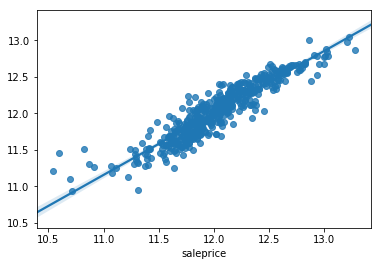

In [83]:
sns.regplot(y_test,  gs_linear.predict(X_test))

## Ridge

Let's try using ridge regression to see if our score turns out better:

In [84]:
ridge_params = {'ridge__alpha': np.logspace(0, 5, 200),
                'ridge__random_state' : [32]}

gs_ridge = GridSearchCV(pipe_ridge, param_grid = ridge_params)

gs_ridge.fit(X_train, y_train)
gs_ridge.score(X_train, y_train)

0.8636718401843019

In [85]:
gs_ridge.score(X_test, y_test)

0.8553708735098431

In [86]:
np.sqrt(mean_squared_error(y_test, gs_ridge.predict(X_test)))

0.15545947287721096

Our ridge model did slightly better than the OLS model after feature selection (1% increase in $R^2$)

In [87]:
gs_ridge.best_score_, gs_ridge.best_params_

(0.8566862816797848,
 {'ridge__alpha': 16.070528182616393, 'ridge__random_state': 32})

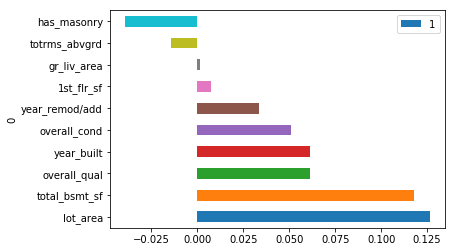

In [88]:
plot_coef(gs_ridge.best_estimator_.named_steps.ridge)

In [89]:
ridge_preds = gs_ridge.predict(test_features)

## Lasso

In [90]:
l_alphas = np.arange(0.001, 0.5, 0.005)

lasso_params = {'lasso__alpha' : l_alphas,
                'lasso__random_state': [32]}

gs_lasso = GridSearchCV(pipe_lasso, param_grid = lasso_params)
gs_lasso.fit(X_train, y_train)
gs_lasso.score(X_train, y_train), gs_lasso.score(X_test, y_test)

(0.8636280160732098, 0.855170771334562)

In [91]:
gs_lasso.best_score_

0.8569538141215437

Our lasso model did about as well as the ridge model.

In [92]:
np.sqrt(mean_squared_error(y_test, gs_lasso.best_estimator_.predict(X_test)))

0.15556697897595184

In [93]:
lasso_preds = gs_lasso.predict(test_features)

In [94]:
lasso_coef_dict = dict(zip(list(gs_lasso.best_estimator_.named_steps.lasso.coef_), X.columns))

## OLS - KBest 10

Based on our lasso-selected parameters, let's run an OLS regression using the 10 features selected by KBest:

In [95]:
lasso_selected = list(lasso_coef_dict.values())

X_lasso_sel = train[lasso_selected]

In [96]:
lr.fit(X_lasso_sel, y)
lr.score(X_lasso_sel, y)

0.8892889848898178

In [97]:
X_train_ls, X_test_ls, y_train_ls, y_test_ls = train_test_split(X_lasso_sel, y)

In [98]:
lr.fit(X_train_ls, y_train_ls)

lr.score(X_train_ls, y_train_ls)

lr.score(X_test_ls, y_test_ls)

0.8750187875794078

In [99]:
np.sqrt(mean_squared_error(y_test_ls, lr.predict(X_test_ls)))

0.1386909535860673

This OLS model improved our R2 score to 0.889 and reduced our RMSE by 0.008.

## Elastic Net

In [100]:
el_params = {'elastic__alpha': np.arange(0.01, 1.0, 0.05),
             'elastic__l1_ratio': np.arange(0.01, 1.0, 0.05)}

gs_el = GridSearchCV(pipe_el, param_grid = el_params)

gs_el.fit(X_train, y_train)
gs_el.score(X_train, y_train)

0.8634239487786813

In [101]:
gs_el.score(X_test, y_test)

0.8548119710412413

In [102]:
np.sqrt(mean_squared_error(y_test, gs_el.predict(X_test)))

0.15575956078546763

In [103]:
gs_el.best_score_

0.8569917040911362

In [104]:
elastic_preds = gs_el.predict(test_features)

Our elastic net model did a little worse at predicting values compared to ridge and lasso alone.

## Composite (for kaggle submission)

In [105]:
composite_preds = (elastic_preds + lasso_preds + ridge_preds)/3